In [1]:
%pylab inline
#import homer
import pandas as pd
import numpy as np
import dask.bag as db
from dask.diagnostics import ProgressBar
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import json
from dask.diagnostics import visualize
import dask
import pickle
from itertools import combinations
import re
import dateutil.parser
from nltk.tokenize import RegexpTokenizer
import ujson
import dask.dataframe as dd
import itertools
from dask import delayed
import collections
import glob
from bokeh.io import output_notebook
output_notebook()

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [31]:
dates = [20150616, 20150617, 20150618, 20150619, 20150620, 20150621, 20150622]
tw_files='/Users/houghton/Desktop/tw/posts_sample_201506*.gz'

In [2]:
dates = [20150615]
thresholds = [1]
tw_files='tests/resources/small_tw_file*.gz'

In [2]:
dates = [20150615, 20150616, 20150617, 20150618, 20150619, 20150620, 
         20150621, 20150622, 20150623, 20150624, 20150625]

sw_file = "homer/stopwords.pickle"
tw_stopwords = pickle.load(open(sw_file, "rb"))

tokenizer = RegexpTokenizer(r'\w+')
matcher = re.compile(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*')

languages = ['en']
def fold_pairs(counter, json_string):
    parsed_json = ujson.loads(json_string)
    if ('lang' in parsed_json and
            'text' in parsed_json and
            parsed_json['lang'] in languages):
        text = parsed_json['text'].lower()

        # remove hyperlinks
        text = matcher.sub('', text)

        # tokenize, dropping punctuation
        tokens = tokenizer.tokenize(text)  # this should release GIL - be ok for parallelization

        # drop stopwords
        tokens = filter(lambda x: x not in tw_stopwords, tokens)

        date = int(dateutil.parser.parse(parsed_json['created_at']).strftime("%Y%m%d"))
        
        if date not in counter:
            counter[date] = collections.Counter()
        for pair in combinations(tokens, 2):
            counter[date][tuple(sorted(pair))] += 1

    return counter


def name_counter():
    for i in range(1000):
        yield i
        
nc = name_counter()

def merge_folds(a, b):
    if isinstance(a, dict):
        for date, c in a.items():
            if len(c):
                pd.Series(c).to_csv('/Users/houghton/Desktop/tw/charleston/wel_%i_%s.csv'%(
                        date, str(time.time()).replace('.', '_')+'a'))

    if isinstance(b, dict):
        for date, c in b.items():
            if len(c):
                pd.Series(c).to_csv('/Users/houghton/Desktop/tw/charleston/wel_%i_%s.csv'%(
                        date, str(time.time()).replace('.', '_')+'b'))

    return None

In [33]:
lines = db.read_text(tw_files, compression='gzip', collection=True)

initial_counter = {date:collections.Counter() for date in dates}
counters = lines.fold(binop=fold_pairs, combine=merge_folds, initial=initial_counter)
        

In [ ]:
with Profiler() as prof, ResourceProfiler(dt=5) as rprof, CacheProfiler() as cprof:
    counts = counters.compute()

visualize([prof, rprof, cprof])  

In [3]:
def sum_files(files):
    collector = pd.DataFrame(columns=['W1', 'W2', 'Count']).set_index(['W1', 'W2'])
    for csv_file in files:
        df = pd.read_csv(csv_file, names=['W1', 'W2', 'Count']).set_index(['W1', 'W2'])
        collector = collector.add(df, fill_value=0)
    return collector.astype(int)

In [6]:
def handle_day(date, threshold=20):
    csv_files = glob.glob('/Users/houghton/Desktop/tw/charleston/wel_%i_*.csv' % date)
    totals = sum_files(csv_files)
    keepers = totals[totals['Count']>=threshold]
    keepers.to_csv('/Users/houghton/Desktop/tw/reduced/wel_total_%i.csv' % date)
    return date

lazy_handle_day = delayed(handle_day)

In [7]:
bag = db.from_delayed([lazy_handle_day(date) for date in dates])

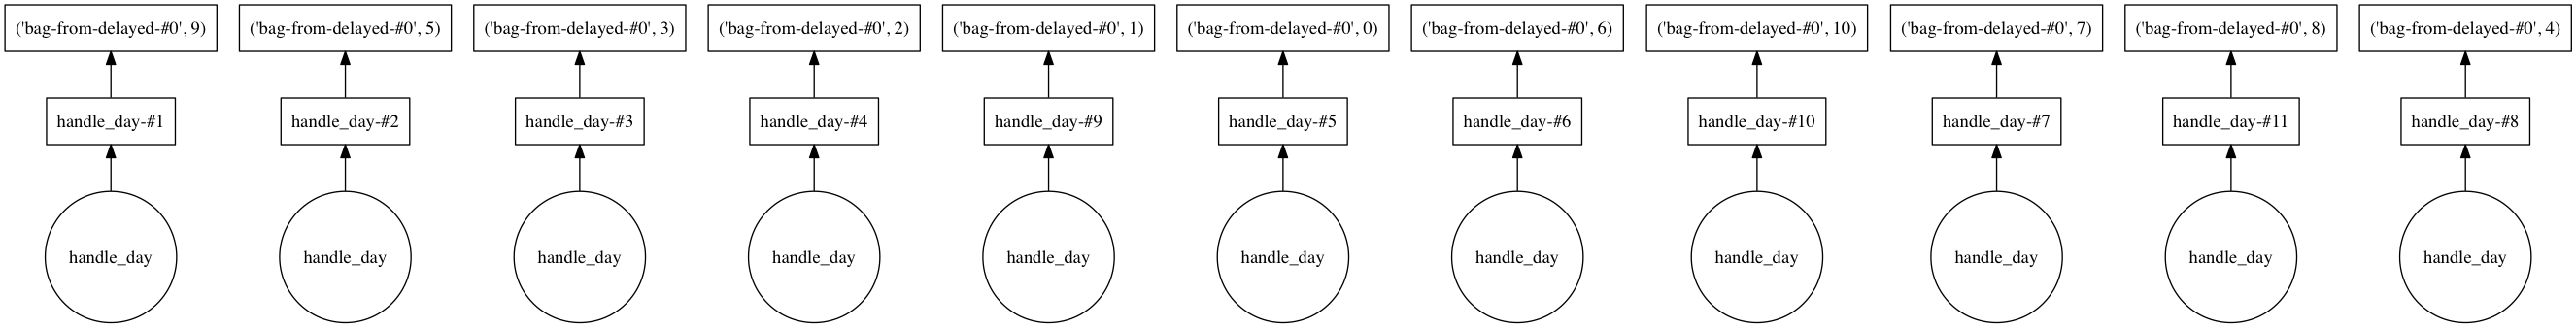

In [8]:
dask.visualize(bag)

In [9]:
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    bag.compute()

visualize([prof, rprof, cprof])  


Column(id='a20485d2-b9f8-432b-b4a7-29b5062f2fc0', ...)

In [52]:
collector = pd.DataFrame(columns=['W1', 'W2', 'Count']).set_index(['W1', 'W2'])
df = pd.read_csv(csv_files[0], names=['W1', 'W2', 'Count']).set_index(['W1', 'W2'])

In [46]:
collector.to_csv

,,Count
W1,W2,


In [54]:
collector.add(df, fill_value=0)

Count
W1      W2              
0       0              3
        00             2
        02             1
        03             2
        05             2
        06             1
        07am           1
        08             2
        09             2
        09am           1
        1              6
        10             2
        100            1
        11             1
        12             1
        13             1
        14             1
        15             3
        16             3
        17             2
        1mph           2
        2              1
        2015           3
        21             1
        22             1
        3              1
        3808500313     1
        4              1
        49             1
        5              1
...                  ...
ｏ       ｏｎｌｙ           2
        ｒ              2
        ｒｅｔｗｅｅｔ        2
        ｓ              2
        ｗ              2
        ｗａｎｔ           2
        ｙｏｕ            2
ｏｎｌｙ    ｒ              1
        ｒｅｔｗｅｅｔ        2
        ｓ              1
        ｗ              1
        ｗａｎｔ           1
        ｙｏｕ            2
ｒ       ｒｅｔｗｅｅｔ        1
        ｓ              1
        ｗ              1
        ｗａｎｔ           1
        ｙｏｕ            1
ｒｅｔｗｅｅｔ ｓ              1
        ｔｈｅｙ           1
        ｗ              1
        ｗａｎｔ           1
        ｙｏｕ            3
ｓ       ｗ              1
        ｗａｎｔ           1
        ｙｏｕ            1
ｔｈｅｙ    ｙｏｕ            1
ｗ       ｗａｎｔ           1
        ｙｏｕ            1
ｗａｎｔ    ｙｏｕ            2

[157005 rows x 1 columns]

In [34]:
totals = file_bag.accumulate(lambda a,b: a.add(b, fill_value=0))

In [19]:
totals = file_bag.fold(binop=lambda a,b: , combine=lambda a,b: a.add(b, fill_value=0))

In [40]:
file_bag.take(10)

/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/bag/core.py:1641: UserWarning: Insufficient elements for `take`. 10 elements requested, only 1 elements available. Try passing larger `npartitions` to `take`.
  "to `take`.".format(n, len(r)))


('Count',)

In [35]:
res = totals.compute()

AttributeError: 'str' object has no attribute 'add'

Traceback
---------
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 268, in execute_task
    result = _execute_task(task, data)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/async.py", line 249, in _execute_task
    return func(*args2)
  File "/Users/houghton/anaconda/envs/py3k/lib/python3.5/site-packages/dask/bag/core.py", line 1180, in accumulate_part
    res = list(accumulate(binop, seq, initial=initial))
  File "cytoolz/itertoolz.pyx", line 108, in cytoolz.itertoolz.accumulate.__next__ (cytoolz/itertoolz.c:3167)
  File "<ipython-input-34-df6f99dc9abb>", line 1, in <lambda>
    totals = file_bag.accumulate(lambda a,b: a.add(b, fill_value=0))


In [ ]:
dd.read_csv('/Users/houghton/Desktop/tw/charleston/wel_20150615_*.csv')